# Обучение моделей на объединенном UNITE и отдельных датасетах DEAP, DREAMER, MEEG

Ссылка на на яндекс диск, где лежат признаковые описания: https://disk.360.yandex.com/d/RVfh2ehMTutz9A

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import random
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from collections import Counter

np.random.seed(42)

Загрузим датасеты, поделенные на трейн и тестовые подвыборки:

In [27]:
unite_train

,subject_id,video_id,valence,arousal,dominance,liking,Low/high valence,Low/high arousal,quadrant,baseline_features,last_10sec_features,div_features,dataset,set
40,2,1,9.00,5.03,7.13,6.62,high,high,HAHV,"[49.66174267486307, 33769.65736687492, 158.168...","[34.79140308199117, 51292.01465460067, 77.3862...","[-0.5440192815222129, -0.7535869530690492, -0....",deap,Обучение
43,2,4,6.05,1.00,5.04,7.03,high,low,LAHV,"[55.95392530702542, 19396.038733203808, 284.55...","[30.914542516963195, 38068.23083461952, 118.72...","[-0.696846212296726, -0.5932957440340828, -0.6...",deap,Обучение
44,2,5,5.04,3.00,3.65,5.04,high,low,LAHV,"[73.32664454074855, 35301.54372352632, 261.230...","[31.516904848316585, 42496.83715635834, 80.223...","[-0.8234745280506556, -0.8673776714293288, -0....",deap,Обучение
47,2,8,9.00,9.00,9.00,9.00,high,high,HAHV,"[31.851199956500015, 19670.060739166056, 162.3...","[20.08113767912198, 27857.056844462953, 81.252...","[-0.6163728259373981, -0.7906663697164612, -0....",deap,Обучение
49,2,10,4.99,1.00,9.00,1.00,low,low,LALV,"[47.38226038177507, 11599.953817060335, 264.85...","[38.03006171558975, 48724.20553720131, 188.204...","[-0.4386840252220711, 0.21491026713145164, -0....",deap,Обучение
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,23,13,4.00,3.00,3.00,NaN,high,high,HAHV,"[2.8156704181403967e-21, 1.8963489542507462e-1...","[1.6362782580640078e-20, 2.0187805578141288e-1...","[-0.2906602148029129, -0.28701442460938204, -0...",dreamer,Обучение
409,23,14,2.00,2.00,2.00,NaN,low,low,LALV,"[8.234650144191223e-22, 5.70850498066084e-18, ...","[3.776974441695046e-21, 4.73775956560712e-18, ...","[-0.2906602148091022, -0.2870144246160763, -0....",dreamer,Обучение
410,23,15,2.00,2.00,2.00,NaN,low,low,LALV,"[7.663218965158619e-22, 5.0619032175036195e-18...","[1.0595188915942948e-21, 1.274798495589696e-18...","[-0.2906602148252956, -0.2870144246325715, -0....",dreamer,Обучение
411,23,16,3.00,3.00,2.00,NaN,high,high,HAHV,"[8.057842375308828e-22, 5.3430858089514716e-18...","[2.9874954772298985e-22, 3.5068744035127164e-1...","[-0.2906602148304095, -0.28701442463788457, -0...",dreamer,Обучение


In [2]:
# объединим датасеты по отдельности
unite_train = pd.read_pickle('unite_train_public.pkl')
unite_test = pd.read_pickle('unite_test_public.pkl')
unite_test_new_subj_old_vid = pd.read_pickle('unite_test_new_subj_old_vid_public.pkl')
unite_test_new_vid_old_subj = pd.read_pickle('unite_test_new_vid_old_subj_public.pkl')

In [4]:
plt.rcParams.update({
    'font.size': 16,            # базовый размер шрифта
    'axes.titlesize': 16,       # заголовки подграфиков
    'axes.labelsize': 14,       # подписи осей
    'xtick.labelsize': 12,      # подписи по оси X
    'ytick.labelsize': 12,      # подписи по оси Y
    'legend.fontsize': 12,      # легенда
    'figure.titlesize': 17      # заголовок всей фигуры (если есть)
})

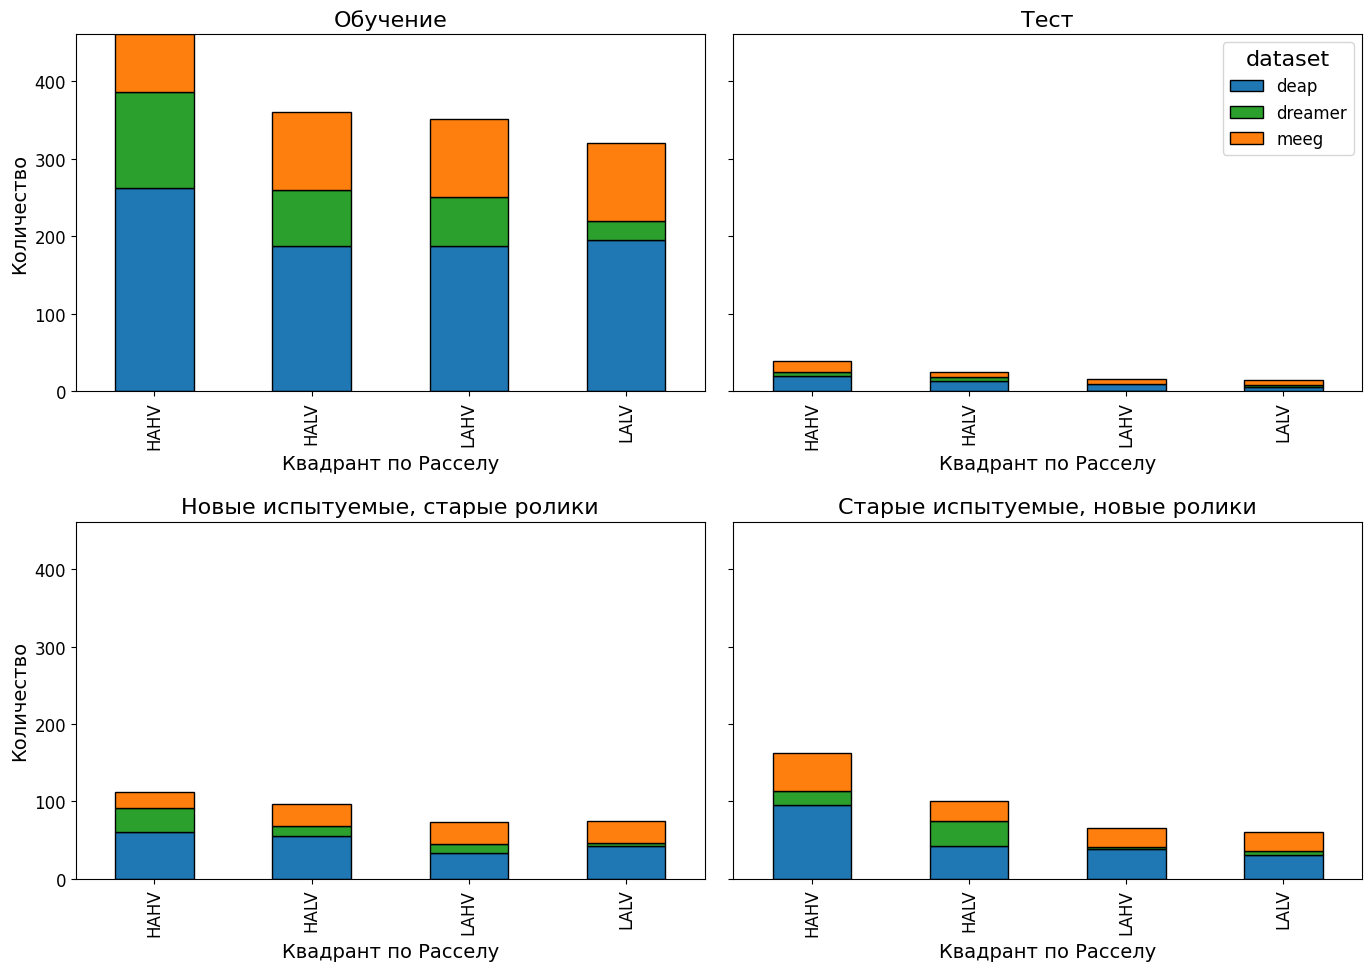

In [9]:
# покажем распределение классов для датасетов
dfs_combined = pd.concat([
    unite_train, unite_test, unite_test_new_subj_old_vid, unite_test_new_vid_old_subj,
])

# Порядок квадрантов
quadrant_order = ['HAHV', 'HALV', 'LAHV', 'LALV']

# Цвета для разных датасетов
colors = {
    'deap': '#1f77b4',
    'meeg': '#ff7f0e',
    'dreamer': '#2ca02c'
}
labels = ['Обучение', 'Тест', 'Новые испытуемые, старые ролики', 'Старые испытуемые, новые ролики']
# Строим графики
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
max_count = 0

for i, ax in enumerate(axes.flatten()):
    subset = dfs_combined[dfs_combined['set'] == labels[i]]
    count_by_dataset = subset.groupby(['quadrant', 'dataset']).size().unstack(fill_value=0).reindex(quadrant_order, fill_value=0)
    
    count_by_dataset.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in count_by_dataset.columns], edgecolor='black', legend=(i == 1))
    ax.set_title(labels[i])
    ax.set_xlabel('Квадрант по Расселу')
    ax.set_ylabel('Количество')
    max_count = max(max_count, count_by_dataset.sum(axis=1).max())

for ax in axes.flatten():
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

### Обучим модели на классификацию 4 классов - UNITE

In [10]:
def bootstrap_metric(y_true, y_pred, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    y_true = np.array(y_true) 
    y_pred = np.array(y_pred)
    b_metric = np.zeros(samples_cnt)
    for i in range(samples_cnt):
        poses = np.random.choice(y_true.shape[0], size=y_true.shape[0], replace=True)

        y_true_boot = y_true[poses]
        y_pred_boot = y_pred[poses]
        m_val = metric_fn(y_true_boot, y_pred_boot)
        b_metric[i] = m_val

    return b_metric

In [13]:
def train_and_test_classifier(models: Dict, train_df_epochs, test_df_epochs,
                              test_new_subj_old_vid_epochs, test_new_vid_old_subj_epochs, verb=True) -> pd.DataFrame:
    """
    Функция берет models: dict, который содержит инициализированные модели, обучает их, 
    а после тестирует с помощью balanced_accuracy. Результат обучения заносится в pd.DataFrame.
    """

    # Label Encoding для всех наборов
    le = LabelEncoder()
    le.fit(train_df_epochs['quadrant'])  # обучаем по train'у (лучше, чем по всем сразу)

    train_df_epochs = train_df_epochs.copy()
    test_df_epochs = test_df_epochs.copy()
    test_new_subj_old_vid_epochs = test_new_subj_old_vid_epochs.copy()
    test_new_vid_old_subj_epochs = test_new_vid_old_subj_epochs.copy()

    train_df_epochs['quadrant_encoded'] = le.transform(train_df_epochs['quadrant'])
    test_df_epochs['quadrant_encoded'] = le.transform(test_df_epochs['quadrant'])
    test_new_subj_old_vid_epochs['quadrant_encoded'] = le.transform(test_new_subj_old_vid_epochs['quadrant'])
    test_new_vid_old_subj_epochs['quadrant_encoded'] = le.transform(test_new_vid_old_subj_epochs['quadrant'])

    # train
    x_train = np.stack(train_df_epochs['last_10sec_features'].values, axis=0)
    y_train = train_df_epochs['quadrant_encoded']

    # test
    x_test = np.stack(test_df_epochs['last_10sec_features'].values, axis=0)
    y_test = test_df_epochs['quadrant_encoded']

    # corner test
    x_test_new_subj_old_vid = np.stack(test_new_subj_old_vid_epochs['last_10sec_features'].values, axis=0)
    y_test_new_subj_old_vid = test_new_subj_old_vid_epochs['quadrant_encoded']

    x_test_new_vid_old_subj = np.stack(test_new_vid_old_subj_epochs['last_10sec_features'].values, axis=0)
    y_test_new_vid_old_subj = test_new_vid_old_subj_epochs['quadrant_encoded']

    results_list = []  # Список для хранения всех результатов

    for name, model in models.items():
        model.fit(x_train, y_train)

        # Обычное тестирование
        y_pred = model.predict(x_test)
        test_scores = bootstrap_metric(y_test, y_pred, metric_fn=balanced_accuracy_score)
        test_mean, test_ci_lower, test_ci_upper = np.mean(test_scores), np.percentile(test_scores, 2.5), np.percentile(test_scores, 97.5)

        # "Новые субъекты, старые видео"
        y_pred_new_subj_old_vid = model.predict(x_test_new_subj_old_vid)
        test_new_subj_old_vid_scores = bootstrap_metric(
            y_test_new_subj_old_vid, y_pred_new_subj_old_vid, 
            metric_fn=balanced_accuracy_score
        )
        test_new_subj_old_vid_mean, test_new_subj_old_vid_ci_lower, test_new_subj_old_vid_ci_upper = (
            np.mean(test_new_subj_old_vid_scores),
            np.percentile(test_new_subj_old_vid_scores, 2.5),
            np.percentile(test_new_subj_old_vid_scores, 97.5),
        )

        # "Новые видео, старые субъекты"
        y_pred_new_vid_old_subj = model.predict(x_test_new_vid_old_subj)
        test_new_vid_old_subj_scores = bootstrap_metric(
            y_test_new_vid_old_subj, y_pred_new_vid_old_subj, 
            metric_fn=balanced_accuracy_score
        )
        test_new_vid_old_subj_mean, test_new_vid_old_subj_ci_lower, test_new_vid_old_subj_ci_upper = (
            np.mean(test_new_vid_old_subj_scores),
            np.percentile(test_new_vid_old_subj_scores, 2.5),
            np.percentile(test_new_vid_old_subj_scores, 97.5),
        )

        results_list.append({
            "model": name,
            "test_mean": test_mean,
            "test_ci_lower": test_ci_lower,
            "test_ci_upper": test_ci_upper,
            "test_new_subj_old_vid_mean": test_new_subj_old_vid_mean,
            "test_new_subj_old_vid_ci_lower": test_new_subj_old_vid_ci_lower,
            "test_new_subj_old_vid_ci_upper": test_new_subj_old_vid_ci_upper,
            "test_new_vid_old_subj_mean": test_new_vid_old_subj_mean,
            "test_new_vid_old_subj_ci_lower": test_new_vid_old_subj_ci_lower,
            "test_new_vid_old_subj_ci_upper": test_new_vid_old_subj_ci_upper
        })

        if verb:
            print(f"Fitted {name} with mean balanced accuracy: {test_mean:.3f}")

    return pd.DataFrame(results_list)

In [14]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42,
                            learning_rate=0.1,
                            n_jobs=-1)
}

In [15]:
df_result_unite_4class = train_and_test_classifier(models, unite_train, unite_test,
                              unite_test_new_subj_old_vid, unite_test_new_vid_old_subj)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitted Logistic Regression with mean balanced accuracy: 0.199
Fitted Random Forest with mean balanced accuracy: 0.324
Fitted Gradient Boosting with mean balanced accuracy: 0.275
Fitted Support Vector Machine with mean balanced accuracy: 0.250
Fitted K-Nearest Neighbors with mean balanced accuracy: 0.299
Fitted Naive Bayes with mean balanced accuracy: 0.237
Fitted Decision Tree with mean balanced accuracy: 0.295
Fitted XGBoost with mean balanced accuracy: 0.335


In [16]:
df_result_unite_4class.sort_values(by=['test_new_subj_old_vid_mean'], ascending=False)

,model,test_mean,test_ci_lower,test_ci_upper,test_new_subj_old_vid_mean,test_new_subj_old_vid_ci_lower,test_new_subj_old_vid_ci_upper,test_new_vid_old_subj_mean,test_new_vid_old_subj_ci_lower,test_new_vid_old_subj_ci_upper
7,XGBoost,0.334749,0.243055,0.435796,0.343390,0.294273,0.390620,0.486934,0.434890,0.541133
1,Random Forest,0.324206,0.232122,0.422165,0.311450,0.264011,0.360151,0.418348,0.369032,0.467419
2,Gradient Boosting,0.274754,0.181906,0.367612,0.305783,0.260440,0.353325,0.373411,0.322660,0.423845
6,Decision Tree,0.295157,0.208025,0.392037,0.293543,0.245610,0.344093,0.362465,0.314999,0.412365
0,Logistic Regression,0.198762,0.147603,0.258711,0.285908,0.245931,0.326562,0.285342,0.250707,0.324127
4,K-Nearest Neighbors,0.298829,0.213510,0.393838,0.270021,0.229091,0.310864,0.395706,0.342829,0.446751
5,Naive Bayes,0.237082,0.216667,0.250000,0.249250,0.238425,0.260888,0.259533,0.238068,0.283669
3,Support Vector Machine,0.250000,0.250000,0.250000,0.243414,0.235141,0.250000,0.266561,0.245888,0.289624


### DEAP на 4 класса

In [17]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42,
                            learning_rate=0.1,
                            n_jobs=-1)
}

In [18]:
df_result_deap_4class = train_and_test_classifier(models, 
                                                   unite_train[unite_train['dataset'] == 'deap'],
                                                   unite_test[unite_test['dataset'] == 'deap'],
                                                    unite_test_new_subj_old_vid[unite_test_new_subj_old_vid['dataset'] == 'deap'],
                                                    unite_test_new_vid_old_subj[unite_test_new_vid_old_subj['dataset'] == 'deap'])

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Logistic Regression with mean balanced accuracy: 0.115


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Random Forest with mean balanced accuracy: 0.286


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Gradient Boosting with mean balanced accuracy: 0.330
Fitted Support Vector Machine with mean balanced accuracy: 0.250


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted K-Nearest Neighbors with mean balanced accuracy: 0.266
Fitted Naive Bayes with mean balanced accuracy: 0.250


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Decision Tree with mean balanced accuracy: 0.214


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted XGBoost with mean balanced accuracy: 0.372


In [19]:
df_result_deap_4class.sort_values(by=['test_new_subj_old_vid_mean'], ascending=False)

,model,test_mean,test_ci_lower,test_ci_upper,test_new_subj_old_vid_mean,test_new_subj_old_vid_ci_lower,test_new_subj_old_vid_ci_upper,test_new_vid_old_subj_mean,test_new_vid_old_subj_ci_lower,test_new_vid_old_subj_ci_upper
6,Decision Tree,0.214049,0.083572,0.364585,0.330522,0.264735,0.396186,0.322227,0.261048,0.393534
0,Logistic Regression,0.115497,0.050000,0.194458,0.304484,0.237194,0.373635,0.329996,0.265585,0.399593
2,Gradient Boosting,0.329836,0.197912,0.468906,0.289171,0.236845,0.341752,0.401770,0.330264,0.477217
7,XGBoost,0.371995,0.228559,0.500000,0.270749,0.216424,0.323860,0.399180,0.326226,0.469575
1,Random Forest,0.286191,0.163331,0.435980,0.267579,0.210659,0.327046,0.416596,0.350420,0.484401
5,Naive Bayes,0.250083,0.250000,0.250000,0.250759,0.239130,0.262102,0.259438,0.232191,0.292590
3,Support Vector Machine,0.250083,0.250000,0.250000,0.237837,0.222645,0.250000,0.294469,0.256250,0.337505
4,K-Nearest Neighbors,0.265530,0.150290,0.394241,0.229130,0.179299,0.287818,0.378285,0.312957,0.446439


### MEEG на 4 класса

In [20]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42,
                            learning_rate=0.1,
                            n_jobs=-1)
}

In [21]:
df_result_meeg_4class = train_and_test_classifier(models, 
                                                   unite_train[unite_train['dataset'] == 'meeg'],
                                                   unite_test[unite_test['dataset'] == 'meeg'],
                                                    unite_test_new_subj_old_vid[unite_test_new_subj_old_vid['dataset'] == 'meeg'],
                                                    unite_test_new_vid_old_subj[unite_test_new_vid_old_subj['dataset'] == 'meeg'])

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Logistic Regression with mean balanced accuracy: 0.231


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Random Forest with mean balanced accuracy: 0.248


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Gradient Boosting with mean balanced accuracy: 0.318


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Support Vector Machine with mean balanced accuracy: 0.282


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted K-Nearest Neighbors with mean balanced accuracy: 0.339


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Naive Bayes with mean balanced accuracy: 0.282


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Decision Tree with mean balanced accuracy: 0.232


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted XGBoost with mean balanced accuracy: 0.337


In [22]:
df_result_meeg_4class.sort_values(by=['test_new_subj_old_vid_mean'], ascending=False)

,model,test_mean,test_ci_lower,test_ci_upper,test_new_subj_old_vid_mean,test_new_subj_old_vid_ci_lower,test_new_subj_old_vid_ci_upper,test_new_vid_old_subj_mean,test_new_vid_old_subj_ci_lower,test_new_vid_old_subj_ci_upper
7,XGBoost,0.336584,0.185672,0.502335,0.517874,0.422803,0.609672,0.702478,0.623240,0.783869
1,Random Forest,0.248078,0.111778,0.404338,0.428573,0.339876,0.518658,0.534872,0.442862,0.624661
2,Gradient Boosting,0.318388,0.187500,0.459563,0.418500,0.326579,0.511694,0.383387,0.294699,0.470907
4,K-Nearest Neighbors,0.338650,0.171857,0.524322,0.363411,0.273339,0.460280,0.459932,0.366978,0.544732
6,Decision Tree,0.231520,0.112465,0.364293,0.330514,0.240114,0.425904,0.372423,0.282478,0.462503
5,Naive Bayes,0.282363,0.145815,0.430372,0.280598,0.199088,0.366013,0.279644,0.211826,0.355769
3,Support Vector Machine,0.282339,0.150580,0.423839,0.241234,0.167527,0.321124,0.375063,0.303363,0.442503
0,Logistic Regression,0.231056,0.102321,0.378950,0.232926,0.152928,0.312518,0.363404,0.275071,0.451246


### DREAMER на 4 класса

In [23]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42,
                            learning_rate=0.1,
                            n_jobs=-1)
}

In [24]:
df_result_dreamer_4class = train_and_test_classifier(models, 
                                                   unite_train[unite_train['dataset'] == 'dreamer'],
                                                   unite_test[unite_test['dataset'] == 'dreamer'],
                                                    unite_test_new_subj_old_vid[unite_test_new_subj_old_vid['dataset'] == 'dreamer'],
                                                    unite_test_new_vid_old_subj[unite_test_new_vid_old_subj['dataset'] == 'dreamer'])

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Logistic Regression with mean balanced accuracy: 0.353


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Fitted Random Forest with mean balanced accuracy: 0.495


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

Fitted Gradient Boosting with mean balanced accuracy: 0.281
Fitted Support Vector Machine with mean balanced accuracy: 0.353


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

Fitted K-Nearest Neighbors with mean balanced accuracy: 0.425


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

Fitted Naive Bayes with mean balanced accuracy: 0.000


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

Fitted Decision Tree with mean balanced accuracy: 0.210


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

Fitted XGBoost with mean balanced accuracy: 0.351


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2458: Use

In [25]:
df_result_dreamer_4class.sort_values(by=['test_mean'], ascending=False)

,model,test_mean,test_ci_lower,test_ci_upper,test_new_subj_old_vid_mean,test_new_subj_old_vid_ci_lower,test_new_subj_old_vid_ci_upper,test_new_vid_old_subj_mean,test_new_vid_old_subj_ci_lower,test_new_vid_old_subj_ci_upper
1,Random Forest,0.494867,0.333333,0.800000,0.250707,0.215517,0.297804,0.241705,0.181233,0.345858
4,K-Nearest Neighbors,0.424796,0.216667,0.687500,0.244064,0.151770,0.371893,0.261116,0.188716,0.362764
0,Logistic Regression,0.352833,0.333333,0.500000,0.257723,0.178571,0.378262,0.204961,0.140625,0.295240
3,Support Vector Machine,0.352833,0.333333,0.500000,0.250000,0.250000,0.250000,0.245864,0.204545,0.333333
7,XGBoost,0.351174,0.133333,0.619048,0.276634,0.193881,0.372396,0.360079,0.192160,0.533161
2,Gradient Boosting,0.280637,0.055556,0.555556,0.248795,0.154435,0.356467,0.189956,0.086795,0.343156
6,Decision Tree,0.209919,0.000000,0.444792,0.153702,0.090079,0.222059,0.269656,0.133032,0.431260
5,Naive Bayes,0.000000,0.000000,0.000000,0.334455,0.258065,0.462599,0.134729,0.000000,0.294118
